Name: Kaushik Ilango  
CWID: 20011241  
Course: Natural Language Processing   
Notes: I have used the data as is. That is I am going to predict the values in the range of(1-5) instead of binary classification as was in the assignment as a secondary suggestion.  
I have tried to provide comments or reasons for writing certain logic but if I do miss anything please let me know during grading my assignment. Thanks.  

First obviously we import some basic but necessary libraries for preprocessing and array manipulation.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

I am gonna use the pandas library to import the provide dataset into this program variable.

In [2]:
amz_rev = pd.read_csv('amazon_reviews.csv')

Let's do some analysis of the product that was reviewed using some simple commands on the amz_rev dataset

In [3]:
amz_rev.head()

,overall,reviewText
0,4,No issues.
1,5,"Purchased this for my device, it worked as adv..."
2,4,it works as expected. I should have sprung for...
3,5,This think has worked out great.Had a diff. br...
4,5,"Bought it with Retail Packaging, arrived legit..."


As we can see there are just two columns (attributes) for each row so just the review statement and the rating. Now let's see the average rating of the product.

In [4]:
sum(amz_rev['overall'])/len(amz_rev['overall'])

4.587589013224822

4.5875 (approx 4.6). Which means that more than 90% liked product and provided positive reviews. Let's see what he number of each review rating.

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
def plot_count(y,xlabel):
    ax = sns.countplot(x = y)
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
    ax.set_xlabel(xlabel,fontsize=15)

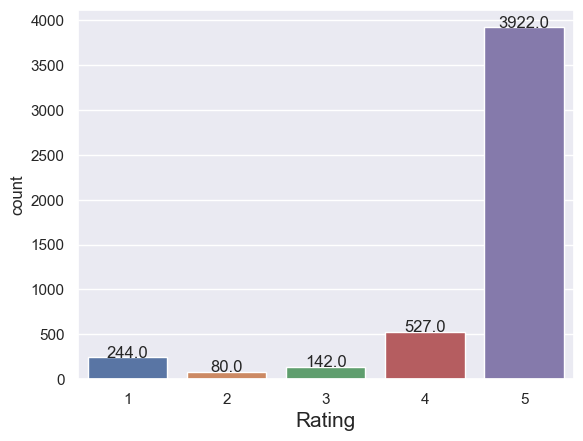

In [6]:
plot_count(amz_rev['overall'],'Rating')
plt.show()

Before we can retrieve more data let's tokenize the review statements so we can gather more insights. For this I am going to directly use the nltk.tokenize module and more specifically the RegexpTokenizer to make it more processable by the model.

In [7]:
from nltk.tokenize import RegexpTokenizer
def setup_data(corpus):
    print("Cleaning data ... ")
    cleaned_corpus = []
    count = 0
    for doc in tqdm(corpus):
        tokenizer = RegexpTokenizer(r'\w+')
        cleaned_corpus.append(tokenizer.tokenize(doc.lower()))
        count = count + 1
    print(f"Done cleaning {count} data")
    return cleaned_corpus

Let's input our whole dataset statements into the new function and look at the output after which we can try to derive some insights. But before we do that we need to replace any missing value in the review statements to "NA" empty or space string. I already ran this once and got an error while trying to convert it to lower since ```nan``` is a float. I am not replacing it with " " since those will be removed and it will again become null string

In [8]:
amz_rev['reviewText'] = amz_rev['reviewText'].replace(np.nan, 'NA', regex=True)
tokenized_data = setup_data(np.array(amz_rev['reviewText']))


Cleaning data ... 


100%|██████████| 4915/4915 [00:00<00:00, 69757.70it/s]

Done cleaning 4915 data


Now we can see the most max used words and least used words to draw some insights.

In [9]:
def draw_insights(corpus):
    min = 0
    max = 0
    total = 0
    for doc in corpus:
        if len(doc) < min:
            min = len(doc)
        if len(doc) > max:
            max = len(doc)
        total = total + len(doc)
    avg = total/len(corpus)
    print(f"Min: {min}, Max: {max}, Avg: {avg}")



In [10]:
draw_insights(tokenized_data)

Min: 0, Max: 1599, Avg: 52.11088504577823


The above results show that the users are dedicated to give a proper review of the product since the avg is at around 52 words which approximately is around 5 lines. Now let's split the data into three parts.

In [11]:
from sklearn.model_selection import train_test_split
def train_test_val_split(X,y, test_size=0.1, val_size = 0.1,random_state=16):
    total_test_size = test_size + val_size
    X_train, X_t, y_train, y_t = train_test_split(X, y, test_size=total_test_size, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_t, y_t, test_size=test_size/total_test_size, random_state=random_state)
    return X_train, X_val, X_test, y_train, y_val, y_test



The above function is just a modified function of the usual train_test_split method in model_selection module which I have developed to provide the validation data set as well.

In [12]:
X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(tokenized_data, np.array(amz_rev['overall']))

Let's run the analysis for the same Train, Test and Validation Data sets

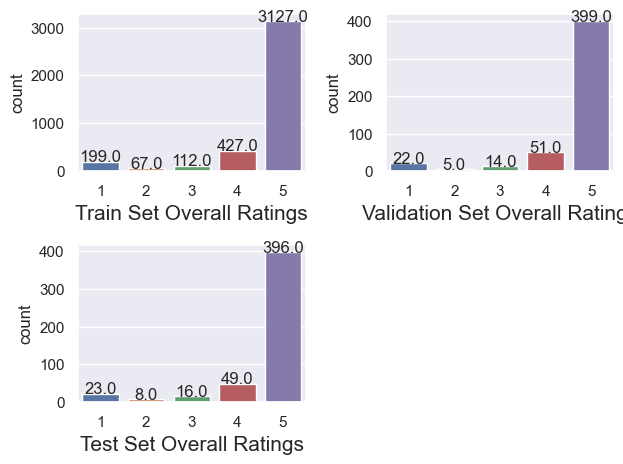

In [13]:
plt.subplot(2,2,1)
plot_count(y_train,xlabel="Train Set Overall Ratings")
plt.subplot(2,2,2)
plot_count(y_val,xlabel="Validation Set Overall Ratings")
plt.subplot(2,2,3)
plot_count(y_test,xlabel="Test Set Overall Ratings")
plt.tight_layout()
plt.show()

Now let's jump into the preprocessing and setting up our embeddings to develop a model. As we have already preprocessed our data using the ```setup_data``` funtion we can use the output to develop a model. Now let's develop a function for retrievinf the vocabulary. There are many ways to do it but I am following the assignment guidelines and using a list comprehension to complete the task.

In [14]:
def get_vocab(corpus):
    vocab = []
    vocab = [x for line in corpus for x in line]
    vocab = list(set(vocab))
    vocab = sorted(vocab)
    return vocab

I have also sorted the words since it was asked to do so which I guess would help in word2index and embedding.

In [15]:
vocab = get_vocab(tokenized_data)

Now let's further dive in and do the complicated part of computing the co-occurence matrix of the whole dataset which would allow us to embed the data and find similarities.

In [16]:
def compute_co_occurence_matrix(corpus,window_size =4):
    word2index = {}
    v = get_vocab(corpus)
    for i in v:
        word2index[i] = v.index(i)
    print(f"Number of unique words {len(v)}")
    x = len(v)
    M = np.zeros((x,x),dtype = 'float32')
    print(M.shape)
    print("Computing pairs...")
    for review in tqdm(corpus):
        for i in range(len(review)):
            for j in range(max(0,i-window_size),min(i+window_size,len(review))):
                if i!=j:
                    M[word2index[review[i]],word2index[review[j]]] += 1
    return M,word2index

In [17]:
M,word2index = compute_co_occurence_matrix(tokenized_data)

Number of unique words 8516
(8516, 8516)
Computing pairs...


100%|██████████| 4915/4915 [00:04<00:00, 1038.73it/s]


Now we have successfully implemented the co-occurence matrix. Now let's try to reduce the dimensions using SVD in specific as mentioned in the assignment we have to use TruncatedSVD.

FYI, I have used float in the Matrix because its easier for numpy to process and decompose it to lower dimensions than working with integers

In [18]:
from sklearn.decomposition import TruncatedSVD
def reduce_to_k_dim(M,k=2):
    print(f"Reducing to {k} dimensions...")
    svd = TruncatedSVD(n_components=k, n_iter=10, random_state=16)
    M_reduced = svd.fit_transform(M)
    return M_reduced

In [19]:
M_reduced = reduce_to_k_dim(M)

Reducing to 2 dimensions...


As mentioned in the assignment we can plot the words using the indices an the 2-d matrix which will provide us with the (x,y) co-ordinates.

In [20]:
def plot_embeddings(M_reduced,word2index,words_to_plot):
    x = []
    y = []
    for word in words_to_plot:
        index = word2index[word]
        x.append(M_reduced[index,0])
        y.append(M_reduced[index,1])
    labels = words_to_plot
    sns.scatterplot(x =x,y = y)
    plt.grid(True)
    for i, label in enumerate(labels):
        plt.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

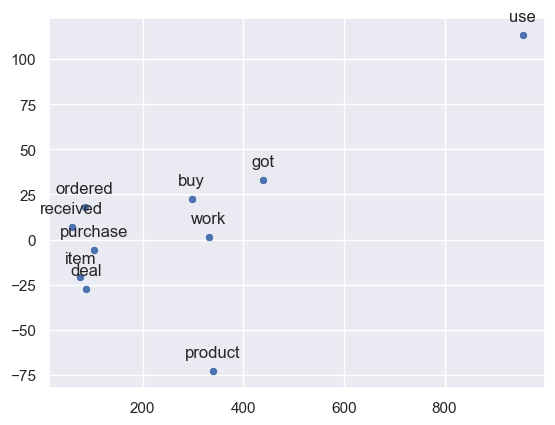

In [21]:
plot_embeddings(M_reduced,word2index,words_to_plot=["purchase", "buy", "work", "got", "ordered", "received", "product", "item", "deal", "use"])

Now let's use the pretrained GloVe embeddings to plot the same above graph. For this we use th predefined definitions as mentioned in the assignment. I am just going to copy paste them in the following cells

In [22]:
import gensim.downloader as api
def load_embedding_model():
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin

In [23]:
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


In [24]:
import random
def get_matrix_of_vectors(wv_from_bin, required_words):

    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ...")
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

Now let's get the matrix and the word2index for this model in ```M2``` and ```word2index2``` variables

In [25]:
M2,word2index2 = get_matrix_of_vectors(wv_from_bin, vocab)

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.


Let's do the same action of reducing the dimensions using our functions and plotting them like we did earlier

Reducing to 2 dimensions...


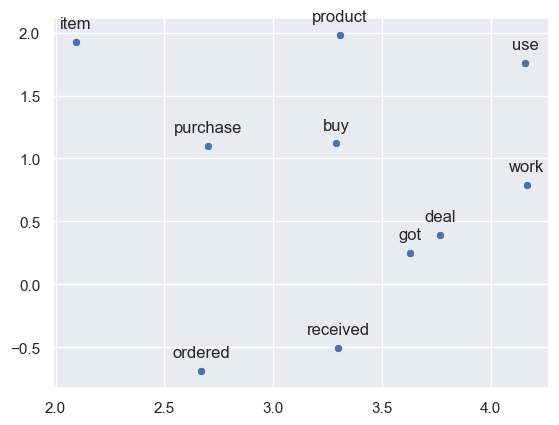

In [26]:
M2_reduced = reduce_to_k_dim(M2)
plot_embeddings(M2_reduced,word2index2,words_to_plot=["purchase", "buy", "work", "got", "ordered", "received", "product", "item", "deal", "use"])

As we can see that this model is not context based whereas our earlier embeddings is context based that is the model was developed on the specific data such as in our case the review dataset so the words had some context before they were plotted and hence it showed up in the plot. Here only the most similar words close to each other even if you consider them close otherwise they are scattered all over the place in this plot. For example 'buy' and 'purchase' have to b as close as possible but they are close but not as closely related as in our context basewd embeddings.

Now let's write a definition for computing the average of each word in the review to get a review embedding

In [27]:
def review_embedding(M,word2index,tokenized_reviews):
    print(M_128.shape)
    review_embeddings = []
    print("Computing review embeddings...")
    for review in tqdm(tokenized_reviews):
        embedding = np.mean([M[word2index[w]] for w in review],axis = 0)
        print(embedding.shape)
        review_embeddings.append(embedding)
    print("Done.")
    return review_embeddings     


Now let's use our embeddings model (co-occurence matrix) to develop a predictive model for the given data set. Let's reduce the dimensions of the matrix M to 128 dimensions to provide more information while still optimizing our run time. I am printing out the shapes just for deubbing since I was getting some errors. But it shows that the each word of shape 128 has been averaged in the review.

In [28]:
M_128 = reduce_to_k_dim(M,k=128)
review_embeddings = review_embedding(M_128,word2index,tokenized_data)

Reducing to 128 dimensions...
(8516, 128)
Computing review embeddings...


 68%|██████▊   | 3341/4915 [00:00<00:00, 16776.33it/s]

(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)

100%|██████████| 4915/4915 [00:00<00:00, 15890.03it/s]

(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)

Converting it into a numpy array to make it faster for computation.

In [29]:
review_embeddings = np.array(review_embeddings)
review_embeddings.shape

(4915, 128)

Now this is our feature dataset which we can use to develop models

In [30]:
X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(review_embeddings, np.array(amz_rev['overall']))

Let's first build a logistic regression model using scikit library. Since this is multilabel (1-5) we need to set some parameters in the regressor.

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

regressor = LogisticRegression(multi_class = 'multinomial',random_state=16,max_iter=1000,penalty = 'l2',C = 1.0)
regressor.fit(X_train,y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=16)

In the above code I set some max_iter values because I was getting an warning that the convergence failed due to less iterations, but that still didnt reduce the warnings so I used standard scaler to scale the values and standardize the data set.

In [33]:
y_val_pred = regressor.predict(X_val)
accuracy_score(y_val,y_val_pred)

0.8105906313645621

In [34]:
y_test_pred = regressor.predict(X_test)
accuracy_score(y_test,y_test_pred)

0.8130081300813008

Getting a pretty good score of 81.3% using logistic regression. Let's try to implement using the Neural Network model.


In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential

model = Sequential(layers = [
    layers.Input(shape = (128,)),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(32,activation = 'relu'),
    layers.Dense(16,activation = 'relu'),
    layers.Dense(6,activation = 'softmax')

])

model.compile(optimizer = 'sgd',loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 6)                 102       
                                                                 
Total params: 10966 (42.84 KB)
Trainable params: 10966 (42.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
history = model.fit(X_train,y_train,epochs = 35,validation_data = (X_val,y_val))

Epoch 1/35
123/123 [==============================] - 1s 3ms/step - loss: 0.9455 - accuracy: 0.7508 - val_loss: 0.7434 - val_accuracy: 0.8126
Epoch 2/35
123/123 [==============================] - 0s 2ms/step - loss: 0.7467 - accuracy: 0.7953 - val_loss: 0.6968 - val_accuracy: 0.8126
Epoch 3/35
123/123 [==============================] - 0s 2ms/step - loss: 0.7192 - accuracy: 0.7953 - val_loss: 0.6771 - val_accuracy: 0.8126
Epoch 4/35
123/123 [==============================] - 0s 2ms/step - loss: 0.7032 - accuracy: 0.7953 - val_loss: 0.6644 - val_accuracy: 0.8126
Epoch 5/35
123/123 [==============================] - 0s 2ms/step - loss: 0.6908 - accuracy: 0.7953 - val_loss: 0.6571 - val_accuracy: 0.8126
Epoch 6/35
123/123 [==============================] - 0s 2ms/step - loss: 0.6799 - accuracy: 0.7953 - val_loss: 0.6471 - val_accuracy: 0.8126
Epoch 7/35
123/123 [==============================] - 0s 2ms/step - loss: 0.6701 - accuracy: 0.7953 - val_loss: 0.6415 - val_accuracy: 0.8126
Epoch 

In [37]:
model.evaluate(X_test,y_test)

16/16 [==============================] - 0s 1ms/step - loss: 0.6404 - accuracy: 0.8110


[0.640353798866272, 0.8109756112098694]

After tuning the parameters I found that the best accuracy for the test without overfitting the data was 81.5 % which is almost the same as the logistic regression. My analysis is that running the newural network for long number of epcohs leads to overfitting of the validation set and doesnt produce the best result in test cases. This is common among the text datasets since once the model trains on the constant dataset it is difficult to understand the context of new texts and hence the predictions go wrong. The neural networks perform better than the logistic regresiion model, but i believe the nural network ca be modified more to add regularization to get a better score than the current score.

I tried adding dropout layers and regularizations in the model. Just a trial.

In [38]:
model_1 = Sequential(layers = [
    layers.Input(shape = (128,)),
    layers.Dense(64,activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(32,activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(16,activation = 'relu'),
    layers.Dense(6,activation = 'softmax')

])
model_1.compile(optimizer = 'adagrad',loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 6)                 102       
                                                                 
Total params: 10966 (42.84 KB)
Trainable params: 10966

In [39]:
history_1 = model_1.fit(X_train,y_train,epochs = 35,validation_data = (X_val,y_val))

Epoch 1/35
123/123 [==============================] - 1s 3ms/step - loss: 1.3331 - accuracy: 0.6562 - val_loss: 1.2044 - val_accuracy: 0.7984
Epoch 2/35
123/123 [==============================] - 0s 2ms/step - loss: 1.1364 - accuracy: 0.7691 - val_loss: 1.0298 - val_accuracy: 0.8106
Epoch 3/35
123/123 [==============================] - 0s 2ms/step - loss: 1.0381 - accuracy: 0.7892 - val_loss: 0.9270 - val_accuracy: 0.8126
Epoch 4/35
123/123 [==============================] - 0s 2ms/step - loss: 0.9771 - accuracy: 0.7930 - val_loss: 0.8668 - val_accuracy: 0.8126
Epoch 5/35
123/123 [==============================] - 0s 2ms/step - loss: 0.9343 - accuracy: 0.7940 - val_loss: 0.8290 - val_accuracy: 0.8126
Epoch 6/35
123/123 [==============================] - 0s 2ms/step - loss: 0.9014 - accuracy: 0.7948 - val_loss: 0.8024 - val_accuracy: 0.8126
Epoch 7/35
123/123 [==============================] - 0s 2ms/step - loss: 0.8900 - accuracy: 0.7950 - val_loss: 0.7838 - val_accuracy: 0.8126
Epoch 

In [40]:
model_1.evaluate(X_test,y_test)

16/16 [==============================] - 0s 1ms/step - loss: 0.6813 - accuracy: 0.8049


[0.6812989711761475, 0.8048780560493469]

In [44]:
!jupyter nbconvert --to pdf model.ipynb

[NbConvertApp] Converting notebook model.ipynb to pdf
[NbConvertApp] ERROR | Error while converting 'model.ipynb'
Traceback (most recent call last):
  File "C:\Users\kilan\AppData\Local\Programs\Python\Python38\lib\site-packages\nbconvert\nbconvertapp.py", line 479, in export_single_notebook
    output, resources = self.exporter.from_filename(
  File "C:\Users\kilan\AppData\Local\Programs\Python\Python38\lib\site-packages\nbconvert\exporters\templateexporter.py", line 389, in from_filename
    return super().from_filename(filename, resources, **kw)  # type:ignore[return-value]
  File "C:\Users\kilan\AppData\Local\Programs\Python\Python38\lib\site-packages\nbconvert\exporters\exporter.py", line 201, in from_filename
    return self.from_file(f, resources=resources, **kw)
  File "C:\Users\kilan\AppData\Local\Programs\Python\Python38\lib\site-packages\nbconvert\exporters\templateexporter.py", line 395, in from_file
    return super().from_file(file_stream, resources, **kw)  # type:ignore[